# Price stock regression 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from DataHelper import get_data, compute_price_difference, compute_tendency

# increase plot size
plt.rcParams["figure.figsize"] = (20,8)

font = {'family' : 'DejaVu Sans',
        'size'   : 20}

matplotlib.rc('font', **font)

In [3]:
DATA_PATH = './data'
FILE = '/AAPL.txt'

In [4]:
df = get_data(DATA_PATH, FILE)
df.head()

,Date,Open,High,Low,Close,Volume,Adjusted
1,2007-01-03,3.081786,3.092143,2.925000,2.992857,1.238320e+09,2.581791
2,2007-01-04,3.001786,3.069643,2.993572,3.059286,8.472604e+08,2.639096
3,2007-01-05,3.063214,3.078571,3.014286,3.037500,8.347416e+08,2.620302
4,2007-01-08,3.070000,3.090357,3.045714,3.052500,7.971068e+08,2.633242
5,2007-01-09,3.087500,3.320714,3.041071,3.306072,3.349298e+09,2.851985


In [5]:
price_column = 'Close'
keep_columns = ['Date', price_column]

In [6]:
df = df.loc[:, keep_columns]

print(len(df))
df.head()

3525


,Date,Close
1,2007-01-03,2.992857
2,2007-01-04,3.059286
3,2007-01-05,3.037500
4,2007-01-08,3.052500
5,2007-01-09,3.306072


In [7]:
df.isna().any()

Date     False
Close    False
dtype: bool

### Preprocessing, compute some indicators

In [8]:
df['Difference'] = compute_price_difference(df, price_column=price_column)

### Compute the price tendency (IE going up or down since yesterday)

In [9]:
THRESH_DIFF = 0.04

df['Tendency'] = compute_tendency(df, diff_column='Difference', labels=['lower','stay', 'high'], thresh_diff=THRESH_DIFF)
value_counts = df.Tendency.value_counts().to_dict()


for value, count in value_counts.items():
    print(f"[{value}] : {count} ({count * 100.0 / len(df['Tendency']):.1f}%)")

[high] : 1583 (44.9%)
[lower] : 1392 (39.5%)
[stay] : 550 (15.6%)


### Add the rolling average

In [10]:
N=10

df[f"MA({N})"] = df[price_column].rolling(N).mean()

print(df.head(15))

          Date     Close  Difference Tendency    MA(10)
1   2007-01-03  2.992857    0.000000     stay       NaN
2   2007-01-04  3.059286    0.066429     high       NaN
3   2007-01-05  3.037500   -0.021786     stay       NaN
4   2007-01-08  3.052500    0.015000     stay       NaN
5   2007-01-09  3.306072    0.253572     high       NaN
6   2007-01-10  3.464286    0.158214     high       NaN
7   2007-01-11  3.421429   -0.042857    lower       NaN
8   2007-01-12  3.379286   -0.042143    lower       NaN
9   2007-01-16  3.467857    0.088571     high       NaN
10  2007-01-17  3.391071   -0.076786    lower  3.257214
11  2007-01-18  3.181072   -0.209999    lower  3.276036
12  2007-01-19  3.160714   -0.020358     stay  3.286179
13  2007-01-22  3.099643   -0.061071    lower  3.292393
14  2007-01-23  3.060714   -0.038929     stay  3.293214
15  2007-01-24  3.096429    0.035715     stay  3.272250


### Shift the prices to predict next day

In [11]:
def shift_prices(df):
    prices = df[price_column]
    prices = prices.shift(periods=-1)    
    df['Next'] = prices
     
shift_prices(df)

print(df)

            Date       Close  Difference Tendency      MA(10)        Next
1     2007-01-03    2.992857    0.000000     stay         NaN    3.059286
2     2007-01-04    3.059286    0.066429     high         NaN    3.037500
3     2007-01-05    3.037500   -0.021786     stay         NaN    3.052500
4     2007-01-08    3.052500    0.015000     stay         NaN    3.306072
5     2007-01-09    3.306072    0.253572     high         NaN    3.464286
...          ...         ...         ...      ...         ...         ...
3521  2020-12-24  131.970001    1.009994     high  127.828001  136.690002
3522  2020-12-28  136.690002    4.720001     high  129.256001  134.869995
3523  2020-12-29  134.869995   -1.820007    lower  130.565000  133.720001
3524  2020-12-30  133.720001   -1.149994    lower  131.149001  132.690002
3525  2020-12-31  132.690002   -1.029999    lower  131.637001         NaN

[3525 rows x 6 columns]


### Remove nulls introduced by previous operations

In [12]:
df = df.dropna()

### ML Data preparation

In [13]:
df = df.drop(columns=['Tendency', 'Date'])

df.head()

,Close,Difference,MA(10),Next
10,3.391071,-0.076786,3.257214,3.181072
11,3.181072,-0.209999,3.276036,3.160714
12,3.160714,-0.020358,3.286179,3.099643
13,3.099643,-0.061071,3.292393,3.060714
14,3.060714,-0.038929,3.293214,3.096429


In [14]:
X = df.loc[:, df.columns != 'Next']
Y = df['Next']

In [15]:
from sklearn.model_selection import train_test_split
TRAIN_RATIO = 0.7

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=TRAIN_RATIO, random_state=42)

print(f"Train size : {len(X_train)}, test size : {len(X_test)} ({(1-TRAIN_RATIO)*100:.0f}%)")

Train size : 2460, test size : 1055 (30%)


### Classifier and evaluation

In [16]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, Y_train)

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = reg.predict(X_test)
print(f"MSE : {mean_squared_error(Y_test, y_pred):.2f}")
print(f"R2_Score : {r2_score(Y_test, y_pred):.2f}")

MSE : 0.61
R2_Score : 1.00


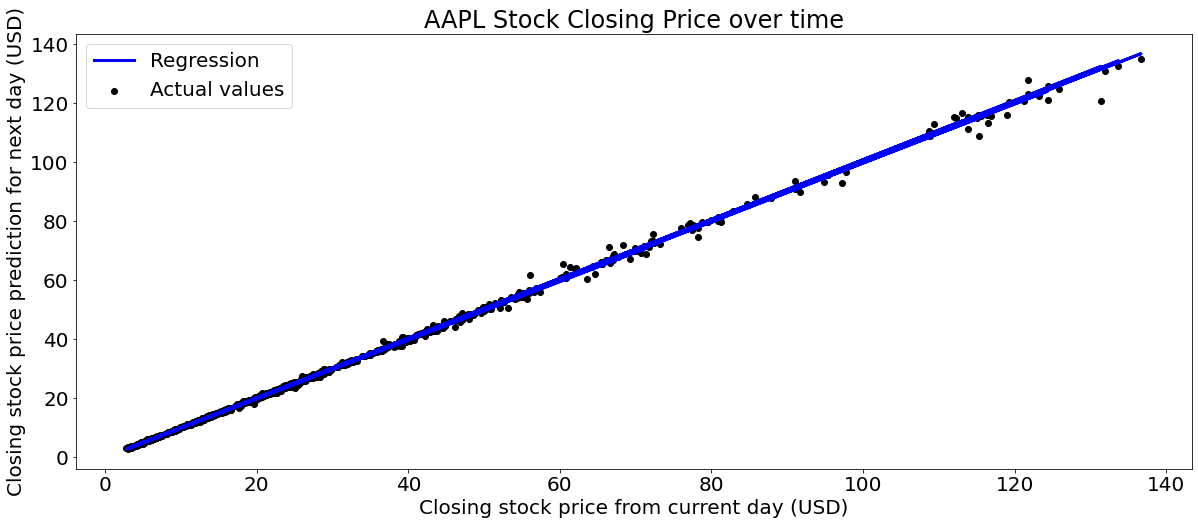

In [34]:
values = X_test[price_column]
ax = plt.gca()
plt.scatter(values, Y_test,  color='black', label="Actual values")
plt.plot(values, y_pred, color='blue', linewidth=3, label="Regression")

ax.set(title='AAPL Stock Closing Price over time', 
       ylabel='Closing stock price prediction for next day (USD)', xlabel='Closing stock price from current day (USD)')
plt.legend(loc='best')
plt.show()